In [2]:
import pandas as pd
import numpy as np

#----------------------------------------------reading the files----------------------------------------------#
healthy = pd.read_csv('data/lusc-rsem-fpkm-tcga_paired.txt', sep='\t')
cancer = pd.read_csv('data/lusc-rsem-fpkm-tcga-t_paired.txt', sep='\t')
pd.options.display.max_columns = None

# copying the data
h = healthy
c = cancer

In [3]:
#----------------------------------------------Files Filteration----------------------------------------------#

# drop the 1st column that identify the genes
h.drop(["Entrez_Gene_Id"], axis = 1, inplace = True)
c.drop(["Entrez_Gene_Id"], axis = 1, inplace = True)

Clength = len(c.columns) # return number of columns after dropping the 1st identification column
droplength = ( 0.5 * (Clength-1) +1) # return the number of 50% of total columns ,+1 because we still have the numeclature column


# replace the zeros (missing values) in file with nan this is required for next step
h = h.replace(0,np.nan)
c = c.replace(0,np.nan)


# in order to remove the rows that have more than 50% missing data dropna function is applied
# in which we put threshold that reflects the minimum number of not nan data required in each row
h = h.dropna(thresh = droplength) 
c = c.dropna(thresh = droplength)


#return back to zero values to proceed calculations
h = h.replace(np.nan,0)
c = c.replace(np.nan,0)

#print(h)
#print(c)

# Extracting the column of hugo_symbol from both files
G_h = h.iloc[0: , 0]
G_c = c.iloc[0: , 0]

# getting the intersected genes in both files according to hugo_symbol extracted from the previous step
common = pd.merge(G_h, G_c, how= 'inner')

# rewriting the 2 files with the common genes only so that each file has the no & name of genes  
h = pd.merge(h, common, how= 'inner', on= ['Hugo_Symbol'])
c = pd.merge(c, common, how= 'inner', on= ['Hugo_Symbol']) 

#print(len(h))
#print(len(c))

In [4]:
#----------------------------------------------pearson (linear) correlation calculation----------------------------------------------#
from scipy.stats import pearsonr

data_corr = []  #a list saves index and correlation
corr_and_gene = []  #a list saves gene name and correlation
mycorr = []      #a list saves correlation value only
G_H = []        # a list saves the genes excluding the 1st column "gene_id" (healthy)
G_C = []        # a list saves the genes excluding the 1st column "gene_id" (cancer)

for x in range(0,len(h)): #len(h) = 17337
    G_h = h.iloc[x, 1:]
    G_c = c.iloc[x, 1:]
    G_H.append(G_h)
    G_C.append(G_c)
    name_gene = h.iloc[x, 0]
    r, _ = pearsonr(G_h, G_c)
    data_corr.append((x,r))
    corr_and_gene.append((name_gene,r))
    mycorr.append(r)
    
#print(len(G_H))
#print(len( G_C)) 


#get maximum corr and index   
max_value = max(mycorr) #Return the max value of the list.
max_index = mycorr. index(max_value) #Find the index of the max value.
max_gene_name = h.iloc[max_index, 0]
min_value = min(mycorr)
min_index = mycorr. index(min_value) #Find the index of the max value.
min_gene_name = h.iloc[min_index, 0]

#sorting the correlation values
mycorr.sort(reverse=True)

In [5]:
print('max CC: ',max_value)
print('index of max CC: ',max_index)
print("max correlation in gene",max_gene_name)
print('min CC: ',min_value)
print('index of min CC: ', min_index)
print("min correlation in gene",min_gene_name)


max CC:  0.9690441442970706
index of max CC:  10829
max correlation in gene AREGB
min CC:  -0.4528072785247083
index of min CC:  12974
min correlation in gene FAM222B


In [6]:
#----------------------------------------------Plotting the results----------------------------------------------#

H_gh = h.iloc[max_index, 1:].astype(np.float)
H_gc = c.iloc[max_index, 1:].astype(np.float)
L_gh = h.iloc[min_index, 1:].astype(np.float)
L_gc = c.iloc[min_index, 1:].astype(np.float)

#Plot
import matplotlib.pyplot as plt

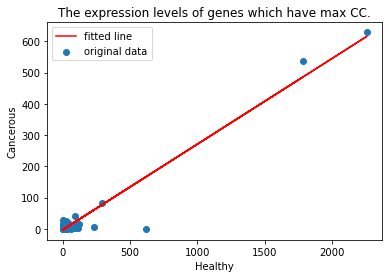

In [7]:
#first plot
plt.scatter(H_gh,H_gc, label='original data')
#curve fitting
m, b = np.polyfit(H_gh, H_gc, 1)
plt.plot(H_gh, m*H_gh + b, c = 'r', label='fitted line')
plt.title('The expression levels of genes which have max CC.')
plt.xlabel("Healthy")
plt.ylabel('Cancerous')
plt.legend()
plt.show()

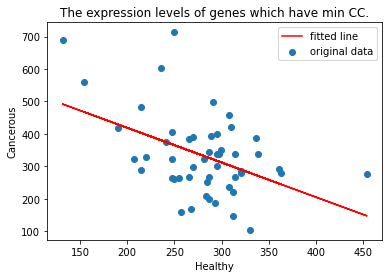

In [8]:
#second plot
plt.scatter(L_gh,L_gc, label='original data')
#curve fitting
m, b = np.polyfit(L_gh, L_gc, 1)
plt.plot(L_gh, m*L_gh + b, c = 'r', label='fitted line')
plt.title('The expression levels of genes which have min CC.')
plt.xlabel("Healthy")
plt.ylabel('Cancerous')
plt.legend()
plt.show()

In [9]:
#----------------------------------------------Hypothesis test----------------------------------------------# 

#Samples are Paired
from scipy.stats import ttest_rel
P_val_paired = []  #list saves P values for paired samples 
for x in range(0,len(h)):
    Gh = G_H[x]
    Gc = G_C[x]
    p_val = ttest_rel(Gh, Gc).pvalue
    P_val_paired.append(p_val)

In [35]:
#Multiple tests correction (FDR Correction) for paired samples
from statsmodels.stats.multitest import multipletests
corrected_P_val_paired = multipletests(P_val_paired, alpha=0.05, method='fdr_bh')[1]

In [11]:
#Samples are independent 
from scipy.stats import ttest_ind
P_val_independent = []  #list saves P values for paired samples 
for x in range(0,len(h)):
    Gh = G_H[x]
    Gc = G_C[x]
    p_val = ttest_ind(Gh,Gc).pvalue
    P_val_independent.append(p_val)

In [12]:
#Multiple tests correction (FDR Correction) for independent samples
from statsmodels.stats.multitest import multipletests
corrected_P_val_independent = multipletests(P_val_independent, alpha=0.05, method='fdr_bh')[1]

In [13]:
# significance_genes paired
gene_names = h.iloc[0: , 0]
significance_genes_paired = pd.DataFrame({'Gene_name':gene_names, 'p-values':P_val_paired, 'p-values_fdr':corrected_P_val_paired})

significance_genes_paired['significance:p_values'] = significance_genes_paired['p-values'].apply(lambda x: x < 0.05)
significance_genes_paired['significance:p_values_fdr'] = significance_genes_paired['p-values_fdr'].apply(lambda x: x < 0.05)

# Get significant genes before fdr correction
diffrentially_genes_paired_b = significance_genes_paired[significance_genes_paired['significance:p_values']== True]

 # To get gene names before fdr
diff_paired_b=diffrentially_genes_paired_b['Gene_name'].to_list()
#print(len(diff_paired_b))

#Get significant genes after fdr correction
diffrentially_genes_paired = significance_genes_paired[significance_genes_paired['significance:p_values_fdr']== True]

# To get gene names after fdr
diff_paired=diffrentially_genes_paired['Gene_name'].to_list()

In [42]:
print(len(diff_paired ))

12410


In [15]:
# significance_genes independent
significance_genes_independent = pd.DataFrame({'Gene_name':gene_names, 'p-values':P_val_independent, 'p-values_fdr':corrected_P_val_independent})
significance_genes_independent['significance:p_values'] = significance_genes_independent['p-values'].apply(lambda x: x < 0.05)
significance_genes_independent['significance:p_values_fdr'] = significance_genes_independent['p-values_fdr'].apply(lambda x: x < 0.05)

# Get significant genes before fdr correction
diffrentially_genes_independent_b = significance_genes_independent[significance_genes_independent['significance:p_values']== True]

# To get gene names before fdr
diff_independent_b=diffrentially_genes_independent_b['Gene_name'].to_list()
#print(len(diff_independent_b))

#Get significant genes after fdr correction
diffrentially_genes_independent = significance_genes_independent[significance_genes_independent['significance:p_values_fdr']== True]

# To get gene names after fdr
diff_independent=diffrentially_genes_independent['Gene_name'].to_list()

In [41]:
print(len(diff_independent))

12320


In [17]:
#Get The distinct values in diff_paired (Not in diff_independent ) after FDR
diff_paired_distinct = [] #a list saves distinct values in DEGs paired sets
DEGs_common = []  #a list saves common values between  DEGs paired sets and independent paired sets
for x in diff_paired:
  if x not in diff_independent:
    diff_paired_distinct.append(x)
  elif x  in diff_independent:
    DEGs_common.append(x)

In [28]:
print(len(DEGs_common))

12241


In [25]:
print(diff_paired_distinct)

['RDH14', 'ZNF354A', 'PLAC8L1', 'MTPN', 'LAMTOR3', 'DOHH', 'ELP5', 'GAA', 'GPT', 'UBR3', 'MED22', 'WDR54', 'CCL7', 'AP3S2', 'SEC16B', 'VTI1A', 'CXXC1', 'HIVEP1', 'AC021860.1', 'EIF3C', 'THAP5', 'IFI44L', 'AC010441.1', 'FZD8', 'SLC38A6', 'C15orf38-AP3S2', 'C12orf71', 'MAP3K2', 'MORN2', 'EDEM3', 'MTRNR2L8', 'FAM27E2', 'SPDYE2', 'NBPF14', 'SLC25A19', 'OAS2', 'ASB7', 'NPIPB4', 'ANAPC2', 'AGBL2', 'NPIPB15', 'ZNF112', 'TMC6', 'TBK1', 'UTY', 'TRIM14', 'NADSYN1', 'GPR42', 'TYMP', 'DCTN2', 'RP13-996F3.5', 'CAPN10', 'AL591684.1', 'AC093157.1', 'FAF2', 'ZNF823', 'HSD11B1L', 'THYN1', 'CENPBD1', 'ZC3H10', 'HIVEP2', 'RMND1', 'SPAG17', 'B3GALT1', 'ARL3', 'ANKRD36', 'ZNF205', 'OPRL1', 'ACIN1', 'GNG12', 'TGFB1', 'UBXN6', 'SOCS5', 'ZNF321P', 'CTAGE8', 'ANO9', 'DHRS4-AS1', 'PLS3', 'NBPF3', 'WASH4P', 'PLGLB2', 'MFSD12', 'MIS18BP1', 'EHBP1L1', 'REST', 'NFKBIL1', 'BIVM', 'C9orf117', 'AGL', 'ALDH1L1', 'ELMOD2', 'SPATA20', 'KLHL36', 'NPIPB5', 'DMAP1', 'GSDMB', 'FCRLB', 'NPIPA5', 'AL354808.2', 'PDGFRL', 'FAM12

In [26]:
print(len(diff_paired_distinct))

169


In [19]:
#Get The distinct values in diff_independent (Not in diff_paired) after FDR
diff_independent_distinct = [] #a list saves distinct values in DEGs independent sets
for x in diff_independent:
  if x not in diff_paired:
    diff_independent_distinct.append(x)

In [30]:
print(diff_independent_distinct)

['SHKBP1', 'TDRKH', 'NMBR', 'GALE', 'IQCJ-SCHIP1', 'POPDC2', 'SLC35E2', 'ALDH1A1', 'SSR4', 'SEC11C', 'ZC3H7B', 'SPECC1', 'TMEM108', 'HUS1B', 'ERBB2', 'ZNF805', 'LRRC31', 'ADAMTS6', 'AKR1CL1', 'ZNF813', 'PGPEP1L', 'ITPRIPL2', 'ITSN1', 'SLC26A4', 'SAMD12', 'LAMC1', 'RBM15', 'EMC7', 'FKBP1A', 'KLHL4', 'C17orf66', 'LCN1', 'INTS9', 'KLK11', 'MYT1', 'EXOSC8', 'TSPO', 'HOXB3', 'NR2C2', 'C22orf31', 'NKAIN4', 'AUTS2', 'AF165138.7', 'SLC9A1', 'DIS3L2', 'RIMS1', 'TOX3', 'GJA9', 'AKAP6', 'WIPF2', 'TGM3', 'RSF1', 'FXYD5', 'CNIH4', 'SHISA9', 'RPL28', 'VPRBP', 'IFNL1', 'FAM222A', 'PAMR1', 'LCT', 'SNRNP27', 'FAM168B', 'SOX13', 'NANOS3', 'NCEH1', 'CNGA3', 'NDUFB8', 'UQCR10', 'EVPL', 'SLC29A1', 'TMEM208', 'SLC22A14', 'NEFM', 'CCDC102A', 'GM2A', 'CP', 'ITPR3', 'RPS6KA6']


In [29]:
print(len(diff_independent_distinct))

79


In [20]:
#Making sure that no common elements between diff_paired_distinct and diff_independent
compare = [] #a list saves an element count in diff_independent (if exists)
for i in diff_paired_distinct:
   compare.append(diff_independent.count(i))
#print(compare) # All its values should equal zero

In [21]:
#Making sure that no common elements between  diff_independent_distinct and diff_paired
Compare = [] #a list saves an element count in diff_paired (if exists)
for i in diff_independent_distinct:
   Compare.append(diff_paired.count(i))
#print(Compare) # All its values should equal zero 

In [45]:
if len(DEGs_common)+len(diff_paired_distinct)==len(diff_paired) and len(DEGs_common)+len(diff_independent_distinct)==len(diff_independent):
    print('The Comparison has been done successfully' )

The Comparison has been done successfully
